	•	Baseline은 예측 기반 운영(Predictive, ESS 없음)으로 정의하였다.
	•	목적함수 J는 피크 초과, 급변 램프 위험도, 평균 램프를 baseline 대비 비율로 정규화하여 가중합으로 구성하였다.
	•	ESS 사용량에 대한 페널티 항을 추가하여 ESS 남용을 억제하였다.
	•	최적화 변수는 임계치 분위수(q_peak), 예측 기반 완화율(alpha_pred), ESS 보조 완화율(beta_ess)로 설정하였다.
	•	ESS 출력·에너지 용량은 가정 파라미터(상수)로 고정하였다.

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

df = pd.read_csv("../data_csv/XGB테스트.csv", parse_dates=["timestamp"])
df = df.set_index("timestamp").sort_index()

df.head()

,actual,pred_xgb
timestamp,,
2013-12-18 05:00:00,5.545,6.632373
2013-12-18 06:00:00,12.552,7.825272
2013-12-18 07:00:00,13.082,12.941123
2013-12-18 08:00:00,19.054,11.586874
2013-12-18 09:00:00,7.159,12.513745


baseline (predictive, ess 없음) 지표

In [3]:
# baseline threshold (95%)
q_base = 0.95
threshold_base = df["actual"].quantile(q_base)

# baseline load (predictive only)
alpha_base = 0.10

df["load_base"] = np.where(
    df["pred_xgb"] > threshold_base,
    df["actual"] * (1 - alpha_base),
    df["actual"]
)

# baseline metrics
peak_base = (df["load_base"] > threshold_base).sum()
ramp_base = df["load_base"].diff().abs()
risky_ramp_base = (ramp_base > ramp_base.quantile(0.95)).sum()
avg_ramp_base = ramp_base.mean()

peak_base, risky_ramp_base, avg_ramp_base

(np.int64(87), np.int64(88), np.float64(4.336684650630012))

ess 가정 파라미터

In [4]:
ESS_power_max = 5.0     # kW
ESS_energy_max = 20.0  # kWh
SOC_init = 10.0        # kWh

목적함수 가중치 정의 

In [5]:
w1 = 0.45  # peak
w2 = 0.45  # risky ramp
w3 = 0.10  # avg ramp
w4 = 0.10  # ESS usage penalty

Grid search 범위 정의

In [6]:
q_peaks = [0.90, 0.93, 0.95, 0.97, 0.99]
alpha_preds = np.arange(0.00, 0.32, 0.02)
beta_ess_list = np.arange(0.00, 0.32, 0.02)

시뮬레이션 목적 함수 계산

In [7]:
def simulate_and_score(q_peak, alpha_pred, beta_ess):
    threshold = df["actual"].quantile(q_peak)
    SOC = SOC_init
    load_opt = []
    ess_used = []

    for t in df.index:
        actual = df.loc[t, "actual"]
        pred = df.loc[t, "pred_xgb"]

        # predictive reduction
        reduction = 0.0
        if pred > threshold:
            reduction += alpha_pred * actual

        # ESS contribution
        ess_output = 0.0
        if pred > threshold and SOC > 0:
            required = beta_ess * actual
            ess_output = min(required, ESS_power_max, SOC)
            SOC -= ess_output
            SOC = max(0, SOC)

        load_opt.append(actual - reduction - ess_output)
        ess_used.append(ess_output)

    load_opt = pd.Series(load_opt, index=df.index)
    ramp = load_opt.diff().abs()

    peak = (load_opt > threshold).sum()
    risky_ramp = (ramp > ramp.quantile(0.95)).sum()
    avg_ramp = ramp.mean()
    ess_energy = np.sum(ess_used)

    # hard constraint
    if (peak > peak_base) and (risky_ramp > risky_ramp_base):
        return None

    J = (
        w1 * (peak / peak_base)
        + w2 * (risky_ramp / risky_ramp_base)
        + w3 * (avg_ramp / avg_ramp_base)
        + w4 * (ess_energy / df["actual"].sum())
    )

    return {
        "q_peak": q_peak,
        "alpha_pred": alpha_pred,
        "beta_ess": beta_ess,
        "Peak": peak,
        "RiskyRamp": risky_ramp,
        "AvgRamp": avg_ramp,
        "ESS_energy": ess_energy,
        "J": J
    }

Grid Search 실행

In [8]:
results = []

for q in q_peaks:
    for a in alpha_preds:
        for b in beta_ess_list:
            out = simulate_and_score(q, a, b)
            if out is not None:
                results.append(out)

results_df = pd.DataFrame(results)
results_df.head()

,q_peak,alpha_pred,beta_ess,Peak,RiskyRamp,AvgRamp,ESS_energy,J
0,0.9,0.0,0.00,175,88,4.341395,0.0,1.455281
1,0.9,0.0,0.02,174,88,4.339921,10.0,1.450134
2,0.9,0.0,0.04,174,88,4.341087,10.0,1.450161
3,0.9,0.0,0.06,174,88,4.341441,10.0,1.450169
4,0.9,0.0,0.08,174,88,4.340853,10.0,1.450156


최적 결과 확인 (J 최소)

In [9]:
best = results_df.sort_values("J").iloc[0]
best

q_peak         0.990000
alpha_pred     0.300000
beta_ess       0.300000
Peak          18.000000
RiskyRamp     88.000000
AvgRamp        4.341395
ESS_energy     0.000000
J              0.643212
Name: 1279, dtype: float64

Baseline vs Optimized 비교 테이블

In [10]:
comparison = pd.DataFrame({
    "Scenario": ["Baseline (Predictive)", "Optimized (ESS + Params)"],
    "Peak Exceedance": [peak_base, best["Peak"]],
    "Risky Ramp": [risky_ramp_base, best["RiskyRamp"]],
    "Average Ramp": [avg_ramp_base, best["AvgRamp"]]
})

comparison

,Scenario,Peak Exceedance,Risky Ramp,Average Ramp
0,Baseline (Predictive),87.0,88.0,4.336685
1,Optimized (ESS + Params),18.0,88.0,4.341395


Trade-off 시각화

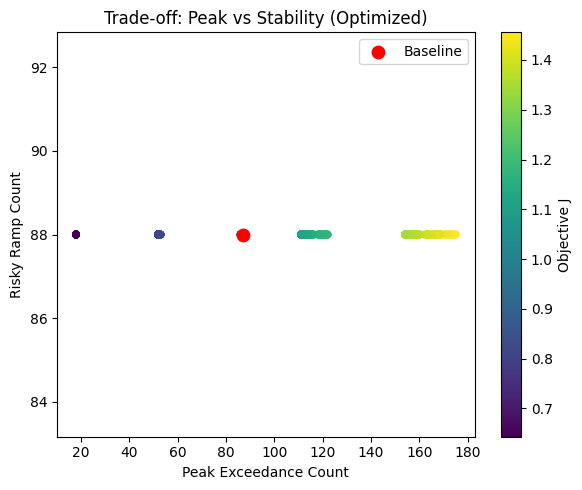

In [11]:
plt.figure(figsize=(6,5))
plt.scatter(
    results_df["Peak"],
    results_df["RiskyRamp"],
    c=results_df["J"],
    cmap="viridis",
    s=20
)
plt.colorbar(label="Objective J")
plt.scatter(
    peak_base, risky_ramp_base,
    color="red", label="Baseline", s=80
)
plt.legend()
plt.xlabel("Peak Exceedance Count")
plt.ylabel("Risky Ramp Count")
plt.title("Trade-off: Peak vs Stability (Optimized)")
plt.tight_layout()
plt.show()

### Core3: Optimization-based Operation Strategy

고정 규칙 기반 예측 운영 및 ESS 적용은 성능 개선에 한계가 있었으며,
운영 파라미터 선택이 결과에 결정적인 영향을 미침을 확인하였다.

Grid search 기반 최적화를 통해,
피크 초과 및 급격한 부하 변화 지표를 동시에 개선하는
운영 파라미터 조합을 도출하였다.

이는 ESS를 포함한 예측 기반 운영 전략에서
단순 규칙이 아닌 최적화 접근의 필요성을 시사한다.